In [1]:
from numpy.random import seed
seed(0)
import tensorflow as tf
tf.set_random_seed(0)
import numpy as np
import scipy.io as sio
import warnings
import keras
import matplotlib.pyplot as plt

from config import params
import peak_det
from importlib import reload
peakdet = reload(peak_det).peakdet

# don't use GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# NaN warnings are ok for now
warnings.filterwarnings("ignore",category = RuntimeWarning) 

# set filepaths 
datapath = '_5track_'
modelname = 'FNN_models/05deep_0512hid_softmax_categorical_crossentropy_16110batch_incoh'
# modelname = '2DCNN_models/05deep_0016hid_softmax_categorical_crossentropy_1024batch_incoh_maxpool'

# Test data parameters #
lim = 1 # degrees (accuracy within)
x_test = np.load(params.fpath + 'test/' + params.fname + 'xtest' + datapath + str(10) + 'snaps.npy')
Nsim = x_test.shape[0] # number of test samples
snr_vec = [0]#,10,20,100]
snap_vec = [10]

print('Number of sources:', params.Nsources)

Using TensorFlow backend.


Number of sources: 5


In [2]:
def peak_picker(inseq, Npeaks, ax, cutoff):
    # picks peaks, based on Matlab FindPeaks and modified for specific input
    
    # inseq, input ambiguity surface 1XM or Mx1 for M classes
    # Npeaks, number of peaks to pick
    # ax, which axis to look along
    # cutoff, minimum peak height, as percentage of max peak
    
    if ax==0:
        pks = peakdet(inseq[:,0], cutoff)
    elif ax==1:
        pks = peakdet(inseq[0,:], cutoff)

    pks = pks[0]
    pks = np.unique(pks, axis=0)
    pksind = (-pks[:,1]).argsort()
    pks = pks[pksind,:]

    pks_out = np.nan*np.ones((Npeaks, 2))
    itern = min(len(pks), Npeaks)
    maxpk = np.max(pks[:,1])
    for i in range(itern):
        if pks[i,:][1] >= cutoff*maxpk:
            pks_out[i,:] = pks[i,:]
        else:
            break
            
    pks_out = np.sort(pks_out, axis=0)
    
    # # # # # Cleaning up and fixing peak picker code; Emma Ozanich May 23, 2019 # # # # # #

    return pks_out

In [3]:
def calc_acc(peaks, I, limit, Nsources):
    # calculates accuracy between true and estimated peak locations
    
    # peaks, N x K matrix of estimate peak locations across samples (N) and number of sources (K)
    # I, N x K matrix of true peak locations
    # limit, degrees within which the estimate = truth is True
    # Nsources, number of sources
    
    acc = np.zeros((1,))
    newpeaks = peaks
    for k in range(Nsources):
        na = np.where(np.isnan(peaks[:,k]))
        if len(na[0])>0:
            for j in na[0]:
                # if the peak was already detected
                if np.sum(np.abs(I[j,k,None]-peaks[j,:])<=limit)>=1:
                    no = np.where(np.abs(I[j,k,None]-peaks[j,:])<=limit)
                    newpeaks[j,k] = peaks[j,no[0][0]] # replace with duplicate detection

        acc = acc + np.sum((np.abs(newpeaks[:,k] - I[:,k]))<=limit)/peaks.shape[0] 
    acc = acc[0]/params.Nsources
    return acc, peaks

In [4]:
def CBF(csdm, params):
    # computes conventional plane wave beamforming 
    
    # csdm, sample covariance matrix at a single sample (may be snapshot averaged, done outside function)
    # params, parameters structure, defined at config.py
    
    u = np.sin(np.deg2rad(params.theta))
    v = np.cos(np.deg2rad(params.theta))
    beam = np.exp(1j*2*np.pi/ params.l* np.outer(params.xq[:,0], u)) / np.sqrt(params.Nsensor)
    cbf = np.abs(np.diag(np.inner( beam.conj().T, np.inner(csdm, beam.T).T)))
    
    return cbf

In [5]:
def format_plot(xlab, ylab, fontsz, xticks, yticks, xticklab, yticklab, legax, legstr, legloc, textloc, textstr, ax):
    # format plots to look nice
    
    # xlab, string, xlabel
    # ylabel, string, ylabel
    # fontsz, float, fontsize
    # xticks, numpy array, xtick locations
    # yticks, numpy array, ytick locations
    # xticklab, list of strings, x tick labels
    # yticklab, list of strings, y tick labels
    # legax, array of plot handles for legend
    # legstr, array of strings for legend labels
    # legloc, integer, location of legend
    # textloc, 2X1 numpy array, x and y location of text
    # textstr, string, text for plot
    # ax, plot axis to format
    
    
    ax.set_xlabel(xlab, fontsize=fontsz)
    ax.set_ylabel(ylab, fontsize=fontsz)
    ax.tick_params(labelsize=fontsz)
    
    # if labels are defined, otherwise use default
    if xticks:
        ax.set_xticks(xticks)
    if yticks:
        ax.set_yticks(yticks)
    if xticklab:
        ax.set_xticklabels(xticklab)    
    if yticklab:
        ax.set_yticklabels(yticklab)
    if legax:
        ax.legend(legax, legstr, loc=legloc, prop={'size': 8})
    if textloc:
        ax.text(textloc[0], textloc[1], textstr, fontsize=20)   
        
    return ax

In [6]:
# # Load the FNN model # #
model = keras.models.load_model(modelname + '.h5')  
print('Loading: ', modelname)

# # # Preallocate # # #
cbf_pks = np.zeros((Nsim, len(snr_vec), len(snap_vec), params.Nsources))
fnn_pks = np.zeros((Nsim, len(snr_vec), len(snap_vec), params.Nsources))
sbl_pks = np.zeros((Nsim, len(snr_vec), len(snap_vec), params.Nsources))

cbf_acc = np.zeros((len(snr_vec), len(snap_vec)))
fnn_acc = np.zeros((len(snr_vec), len(snap_vec)))
sbl_acc = np.zeros((len(snr_vec), len(snap_vec)))

Loading:  FNN_models/05deep_0512hid_softmax_categorical_crossentropy_16110batch_incoh


In [7]:
# # Predict performance across SNR and snapshot # #

for m in range(len(snr_vec)):
    for j in range(len(snap_vec)):
            params.fname = str(snr_vec[m]) + 'dB/'
            x_test = np.load(params.fpath + 'test/' + params.fname + 'xtest' + datapath + str(snap_vec[j]) + 'snaps.npy')
            y_test = np.load(params.fpath + 'test/' + params.fname + 'ytest' + datapath + str(snap_vec[j]) + 'snaps.npy')
            X = np.load(params.fpath + 'test/' + params.fname + 'raw' + datapath + str(snap_vec[j]) + 'snaps.npy')
            labels = np.load(params.fpath + 'test/' + params.fname + 'labels' + datapath + str(snap_vec[j]) + 'snaps.npy')
            
            # # # Preallocate # # #

            I = np.zeros((Nsim, params.Nsources))
            I_fnn = np.zeros((Nsim,params.Nsources))
            I_cbf = np.zeros((Nsim,params.Nsources))
            I_sbl = np.zeros((Nsim,params.Nsources))
            
            # # #   # # #   # # #

            # # ----- Load SBL ----- # #
            inpt = sio.loadmat('%s%s_%02d_snaps_sbl%s' % (params.fpath,str(snr_vec[m]) + 'dB',snap_vec[j],datapath[:-1]))
            sbl = inpt['sbl']
            
            # # ---- Predict FNN ---- # #
            fnn = model.predict(x_test)
            row_max = fnn.max(axis=1)
            fnn = fnn / row_max[:, np.newaxis]

            # # Loop over test samples # #
            for s in range(Nsim):
                
                # # ---- CBF ----- # # 
                csdm = np.inner(X[:,:,s], X[:,:,s].conj())/snap_vec[j]
                cbf = CBF(csdm, params)
                pkstmp = peak_picker(np.abs(cbf[:, np.newaxis]/np.max(cbf)), params.Nsources, 0, 0.1)
                cbf_pks[s,m,j,:] = np.sort(pkstmp[:,0])

                # #  ----- SBL ----- # #
                pkstmp = peak_picker(sbl[s,:, np.newaxis]/np.max(sbl[s,:]), params.Nsources, 0, 0.1)
                sbl_pks[s,m,j,:] = np.sort(pkstmp[:,0])

                # # ----- FNN ----- # #
                pkstmp = peak_picker(np.abs(fnn[s,:,np.newaxis]/np.max(fnn[s,:])), params.Nsources, 0, 0.1)
                fnn_pks[s,m,j,:] = np.sort(pkstmp[:,0])
                
                # true peaks #
                for mm in range(params.Nsources):
                    I[s,mm] = np.argmin(np.abs(params.theta - labels[s,mm]))
                I[s,:] = np.sort(I[s,:])

            # ----------- Compute Errors -------------#
            #(reassign overlapping sources to be identical instead of NaN)#
            cbf_acc[m,j], cbf_pks[:,m,j,:] = calc_acc(cbf_pks[:,m,j,:], I, lim, params.Nsources)
            fnn_acc[m,j], fnn_pks[:,m,j,:] = calc_acc(fnn_pks[:,m,j,:], I, lim, params.Nsources)
            sbl_acc[m,j], sbl_pks[:,m,j,:] = calc_acc(sbl_pks[:,m,j,:], I, lim, params.Nsources)

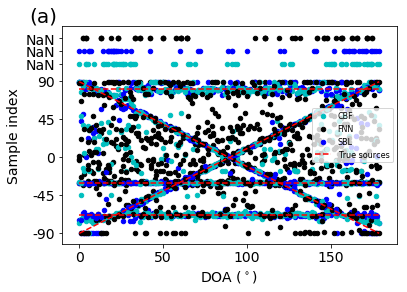

In [8]:
# # plot predictions # #
snr_ind = 0
snap_ind = 0
spks = np.zeros((Nsim, params.Nsources))
fpks = np.zeros((Nsim, params.Nsources))
cpks = np.zeros((Nsim, params.Nsources))
ax = plt.subplot(111)

def label_and_replace_nans(pks_est, params, NanVal):
    # redfines the estimated peaks, replaces Nans with floats outside of axis limits
    
    # peaks_est, Nx1 numpy array of estimated peak indices
    # params, parameter structure from config.py
    # NanVal, value to replace NaNs
    
    new_pks = np.zeros((pks_est.shape[0],))
    NotNan = np.isfinite(pks_est)
    new_pks[NotNan] = params.theta[pks_est[NotNan].astype(int)]
    new_pks[np.isnan(pks_est)] = NanVal
    return new_pks

for mm in range(params.Nsources):
    spks = label_and_replace_nans(sbl_pks[:,snr_ind,snap_ind,mm], params, 125)
    s3 = ax.scatter(np.arange(len(params.theta)), spks, color='b', s=20)
    
    cpks = label_and_replace_nans(cbf_pks[:,snr_ind,snap_ind,mm], params, 110)
    s1 = ax.scatter(np.arange(len(params.theta)), cpks, color='c', s=20)
    
    fpks = label_and_replace_nans(fnn_pks[:,snr_ind,snap_ind,mm], params, 140)
    s2 = ax.scatter(np.arange(len(params.theta)), fpks, color='k', s=20)
    
    p1, = ax.plot(labels[:,mm], 'r--')
    
format_plot('DOA ($^\circ$)', 'Sample index', 14, [], [-90,-45,0,45,90,110,125,140], \
            [], ['-90','-45','0','45','90','NaN','NaN','NaN'], (s1,s2,s3,p1),('CBF','FNN','SBL','True sources'),\
            7, [-30, 160], '(a)', ax)

# plt.savefig()
plt.show()

True sources:  [ 40. -41. -68. -30.  80.]


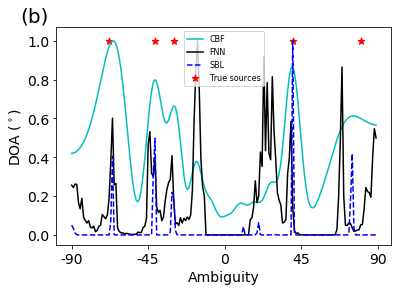

In [9]:
# # plot ambiguity surface at one index # #
st = 130 # sample index
print('True sources: ', labels[st,:])
inpt = sio.loadmat('%s%s_%02d_snaps_sbl%s' % (params.fpath,str(snr_vec[snr_ind]) +\
                                                'dB',snap_vec[snap_ind],datapath[:-1]))
sbl = inpt['sbl']

# ----- CBF ----- # #
csdm = np.inner(X[:,:,st], X[:,:,st].conj())/snap_vec[snap_ind]
cbf = CBF(csdm, params)

ax = plt.subplot(111)
p2, = ax.plot(params.theta, cbf/np.max(cbf), 'c')
p3, = ax.plot(params.theta, fnn[st,:],'k')
p4, = ax.plot(params.theta, sbl[st,:]/np.max(sbl[st,:]),'b--')
for n in range(params.Nsources):
    p1 = ax.scatter(labels[st,n], 1, 50, 'r', marker='*')

format_plot('Ambiguity', 'DOA ($^\circ$)', 14, [-90,-45,0,45,90], [],\
            ['-90','-45','0','45','90'], [], (p2,p3,p4,p1),('CBF','FNN','SBL','True sources'),\
            9, [-120, 1.1], '(b)', ax)

#plt.savefig('5ambiguity_Incoh_5layer_512hn_200epoch_'+ str(snr_vec[0]) +'dB_'+ str(snap_vec[0]) +'snap_fnn_zoom.pdf', bbox_inches='tight')
plt.show()